In [67]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import geopandas as gpd

In [68]:
import os # we need os to do some basic file operations

sentinal_fp = "C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/sentinel/"
# find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinal_fp, f) for f in os.listdir(sentinal_fp) if os.path.isfile(os.path.join(sentinal_fp, f))]
sentinal_band_paths.sort()
sentinal_band_paths

['C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/sentinel/T32UPU_20210814T102031_B02_10m_extent.tif',
 'C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/sentinel/T32UPU_20210814T102031_B03_10m_extent.tif',
 'C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/sentinel/T32UPU_20210814T102031_B04_10m_extent.tif',
 'C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/sentinel/T32UPU_20210814T102031_B05_20m_extent.tif',
 'C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/sentinel/T32UPU_20210814T102031_B06_20m_extent.tif',
 'C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/sentinel/T32UPU_20210814T102031_B07_20m_extent.tif',
 'C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/sentinel/T32UPU_20210814T102031_B08_10m_extent.tif',
 'C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/sentinel/T32UPU_20210814T102031_B8A_20m_extent.tif']

In [149]:
file_path = 'C:/Users/leoni/Documents/Uni/UGS/Project/Classification_data/data/osm_polygon.gpkg'

# Load the dataset
data = gpd.read_file(file_path)
data

osmid              class  \
0       24537862  recreation_ground   
1       24795237  recreation_ground   
2       26552754  recreation_ground   
3       34244079  recreation_ground   
4       34995210  recreation_ground   
...          ...                ...   
6246  1227871965           building   
6247   645024044           building   
6248  1175155694           building   
6249   111755134           building   
6250  1208722589           building   

                                               geometry  
0     POLYGON ((10.89427 48.30580, 10.89428 48.30618...  
1     POLYGON ((10.90226 48.28125, 10.90227 48.28118...  
2     POLYGON ((10.87407 48.36330, 10.87403 48.36304...  
3     POLYGON ((10.92775 48.35498, 10.92767 48.35493...  
4     POLYGON ((10.87226 48.35491, 10.87230 48.35486...  
...                                                 ...  
6246  POLYGON ((10.91509 48.35313, 10.91507 48.35313...  
6247  POLYGON ((10.86227 48.31631, 10.86227 48.31625...  
6248  POLYGON ((10.85076 48.39985, 10.85086 48.39985...  
6249  POLYGON ((10.90005 48.39400, 10.90010 48.39395...  
6250  POLYGON ((10.92128 48.38857, 10.92121 48.38855...  

[6251 rows x 3 columns]

<Axes: >

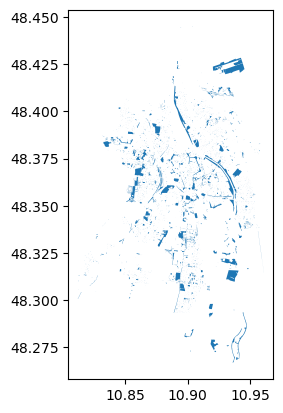

In [150]:
data.plot()

In [151]:
# create a products directory within the data dir which won't be uploaded to Github
img_dir = 'C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/products2/'

# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + 'sentinel_bands.tif'

# Read metadata of first file and assume all other bands are the same
with rasterio.open(sentinal_band_paths[0]) as src0:
    meta = src0.meta

# Update metadata to reflect the number of layers
meta.update(count = len(sentinal_band_paths))

# # Read each layer and write it to stack
# with rasterio.open(img_fp, 'w', **meta) as dst:
#     for id, layer in enumerate(sentinal_band_paths, start=1):
#         with rasterio.open(layer) as src1:
#             dst.write_band(id, src1.read(1))

In [152]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(2197, 1478)
8


In [153]:
full_dataset

<open DatasetReader name='C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/products2/sentinel_bands.tif' mode='r'>

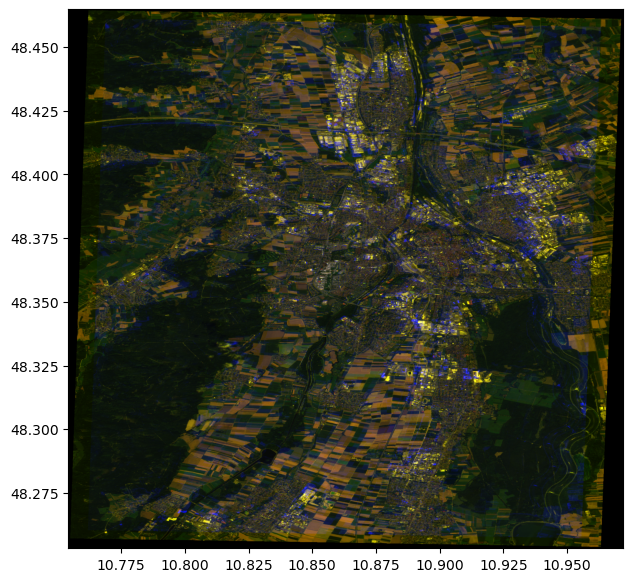

In [154]:
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt

img_fp = 'C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/products2/sentinel_bands_proj.tif'

# Open the full extent of the raster dataset
with rasterio.open(img_fp) as dataset:
    # Read the specified bands (3, 2, 1 for RGB)
    img_data = dataset.read([3, 2, 1])
# Assuming you've already read the img_data
# Scale the data to 0-255 range, assuming it's 16-bit
img_data = np.clip(img_data / 4096 * 255, 0, 255).astype(np.uint8)

# Mask out no data values if necessary
no_data_value = -9999  # Replace with your actual no data value
img_data[img_data == no_data_value] = 0  # Set no data values to 0 for display

# Now display the image
fig, ax = plt.subplots(figsize=(10, 7))
show(img_data, ax=ax, transform=dataset.transform)

plt.show()

In [155]:
full_dataset = rasterio.open(img_fp)
raster_crs = full_dataset.crs

In [156]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define the source and destination coordinate reference systems
src_crs = 'EPSG:32632'
dst_crs = 'EPSG:4326'

# Open the original dataset
with rasterio.open('C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/products/sentinel_bands.tif') as src:
    # Calculate the transform and dimensions for the new dataset
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # Define the metadata for the new dataset
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create the new dataset and reproject the original data into it
    with rasterio.open('C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/products/sentinel_bands_proj.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):  # Loop through all bands
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [157]:
shapefile = gpd.read_file('C:/Users/leoni/Documents/Uni/UGS/Project/Classification_data/data/osm_polygon.gpkg')
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [158]:
shapefile = shapefile.to_crs(epsg=32632)
shapefile.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [159]:
shapefile

osmid              class  \
0       24537862  recreation_ground   
1       24795237  recreation_ground   
2       26552754  recreation_ground   
3       34244079  recreation_ground   
4       34995210  recreation_ground   
...          ...                ...   
6246  1227871965           building   
6247   645024044           building   
6248  1175155694           building   
6249   111755134           building   
6250  1208722589           building   

                                               geometry  
0     POLYGON ((640464.148 5352023.221, 640463.987 5...  
1     POLYGON ((641124.381 5349310.187, 641125.245 5...  
2     POLYGON ((638809.721 5358378.274, 638808.031 5...  
3     POLYGON ((642809.012 5357551.256, 642803.489 5...  
4     POLYGON ((638698.680 5357441.566, 638702.034 5...  
...                                                 ...  
6246  POLYGON ((641876.757 5357322.760, 641874.943 5...  
6247  POLYGON ((638062.869 5353133.172, 638062.913 5...  
6248  POLYGON ((636985.360 5362398.072, 636992.579 5...  
6249  POLYGON ((640649.513 5361837.100, 640653.686 5...  
6250  POLYGON ((642236.480 5361272.707, 642230.813 5...  

[6251 rows x 3 columns]

In [160]:
shapefile = shapefile.to_crs({'init': 'epsg:4326'})
shapefile.crs

c:\Users\leoni\Programme\Miniconda\envs\geo\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [161]:
len(shapefile)

6251

In [162]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((10.8942717 48.3057961, 10.8942839 48.3061844, 10.897539 48.30582540000001, 10.8978662 48.3051395, 10.897797799999998 48.30473709999998, 10.8976798 48.304690799999996, 10.8939032 48.305060100000006, 10.893856299999998 48.30511539999999, 10.893844199999998 48.3052019, 10.893858800000002 48.3056951, 10.893969399999998 48.30569340000001, 10.8942717 48.3057961))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((10.8942717, 48.3057961), (10.8942839, 48.3061844), (10.897539, 48.30582540000001), (10.8978662, 48.3051395), (10.897797799999998, 48.30473709999998), (10.8976798, 48.304690799999996), (10.8939032, 48.305060100000006), (10.893856299999998, 48.30511539999999), (10.893844199999998, 48.3052019), (10.893858800000002, 48.3056951), (10.893969399999998, 48.30569340000001), (10.8942717, 48.3057961)),)}]


In [163]:
out_image, out_transform = mask(full_dataset, feature, crop=True)
out_image.shape

(8, 15, 38)

In [164]:
full_dataset.close()

In [165]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from shapely.geometry import box


# Load the shapefile
#shapefile = gpd.read_file(shapefile_path)

# Check if the CRS matches, if not, reproject
if shapefile.crs != raster_crs:
    shapefile = shapefile.to_crs(raster_crs)

# Check that geometries are valid
shapefile['valid'] = shapefile.is_valid
shapefile = shapefile[shapefile['valid']]


with rasterio.open('C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/products/sentinel_bands_proj.tif') as src:
    raster_bounds = src.bounds
    raster_bbox = box(*raster_bounds)  # Create a bounding box from the raster bounds

    # Only proceed if the raster and shapefile overlap
    if not shapefile.unary_union.intersects(raster_bbox):
        raise ValueError("Shapefile and raster do not overlap")
    else:
        print("The shapefile and raster overlap.")

    # Extract the raster values within the polygon
    for geom in shapefile.geometry:
        feature = [mapping(geom)]
        out_image, out_transform = mask(src, feature, crop=True)
        # process out_image

The shapefile and raster overlap.


### Adjust Landcover Data to match the scene

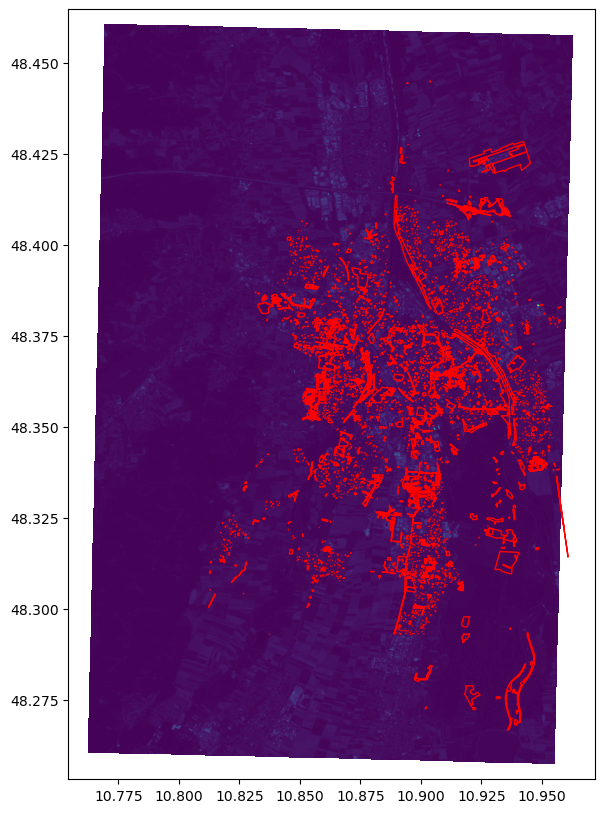

In [166]:
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot

fig, ax = plt.subplots(figsize=(10, 10))
with rasterio.open('C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/products/sentinel_bands_proj.tif') as src:
    rasterio.plot.show(src, ax=ax)
shapefile.plot(ax=ax, facecolor='none', edgecolor='red')
plt.show()

In [167]:
shapefile = shapefile.groupby('class', group_keys=False).apply(lambda x: x.sample(n=10, replace=True))
shapefile

osmid              class  \
4827    99023243           building   
3703   215704128           building   
3466    88589720           building   
5032  1147905239           building   
3481  1155918990           building   
...          ...                ...   
23     104373960  recreation_ground   
18     103528583  recreation_ground   
73      13402430  recreation_ground   
31     133763097  recreation_ground   
69     959729109  recreation_ground   

                                               geometry  valid  
4827  POLYGON ((10.84862 48.34145, 10.84857 48.34145...   True  
3703  POLYGON ((10.90365 48.44504, 10.90384 48.44479...   True  
3466  POLYGON ((10.88108 48.34347, 10.88111 48.34347...   True  
5032  POLYGON ((10.89485 48.36282, 10.89484 48.36284...   True  
3481  POLYGON ((10.87539 48.33969, 10.87539 48.33964...   True  
...                                                 ...    ...  
23    POLYGON ((10.92480 48.37240, 10.92369 48.37301...   True  
18    POLYGON ((10.87870 48.36843, 10.87874 48.36796...   True  
73    POLYGON ((10.93324 48.35319, 10.93666 48.35308...   True  
31    POLYGON ((10.91047 48.31069, 10.91051 48.31067...   True  
69    POLYGON ((10.89074 48.31453, 10.89057 48.31379...   True  

[80 rows x 4 columns]

In [168]:
shapefile.explore()

In [169]:
import numpy as np

# Initialize a list to hold the mean values for each band
band_means = []

# Extract the raster values within the polygon
for geom in shapefile.geometry:
    feature = [mapping(geom)]
    
    with rasterio.open('C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/products/sentinel_bands_proj.tif') as src:
        out_image, out_transform = mask(src, feature, crop=True)
        
        # Calculate mean of each band, excluding no-data values
        means = np.ma.array(out_image, mask=out_image == src.nodata).mean(axis=(1, 2))
        band_means.append(means.filled(src.nodata))

In [170]:
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
from rasterio.features import geometry_mask

img_fp = 'C:/Users/leoni/Documents/Uni/UGS/Project/RandomForest/data_a/products/sentinel_bands_proj.tif'

X = np.array([], dtype=np.float32).reshape(0, 8)  # Replace '8' with the actual number of bands if different
y = []  # Initialize y as an empty list

incomplete_features = []

with rasterio.open(img_fp) as src:
    raster_crs = src.crs
    nodata = src.nodatavals[0]  # Assuming all bands have the same nodata value
    band_count = src.count

    # Iterate over the geometries in the shapefile
    for index, row in shapefile.iterrows():
        geom = row['geometry']
        # Create a mask for the current geometry
        geom_mask = geometry_mask([geom], transform=src.transform, invert=True, out_shape=(src.height, src.width))

        # Check if the geometry intersects with the raster
        if not geom_mask.all():
            out_image, out_transform = mask(src, [geom], crop=True, nodata=nodata)
            out_image_masked = np.ma.masked_equal(out_image, nodata)
            valid_data = out_image_masked.compressed()

            # Ensure we have a complete set of pixels for all bands
            if valid_data.size % band_count == 0:
                out_image_reshaped = valid_data.reshape(-1, band_count)

                # Remove rows that contain nodata values
                valid_rows = np.all(out_image_reshaped != nodata, axis=1)
                out_image_reshaped = out_image_reshaped[valid_rows]

                # Only proceed if we have valid data left after removing nodata rows
                if out_image_reshaped.size > 0:
                    X = np.vstack((X, out_image_reshaped))
                    y.extend([row['class']] * out_image_reshaped.shape[0])
            else:
                # Collect indices of incomplete features to handle later
                incomplete_features.append(index)
                print(f"Feature {index} does not have a complete set of pixels.")

# Handle incomplete features as needed
# For example, you might want to drop them from the shapefile
shapefile = shapefile.drop(incomplete_features)

In [171]:
# Initialize empty arrays for the pixel values and labels
X = np.array([], dtype=np.float32).reshape(0, 8)  # Replace '8' with the number of bands
y = []

with rasterio.open(img_fp) as src:
    # Ensure the shapefile is in the same CRS as the raster
    shapefile = shapefile.to_crs(src.crs)
    nodata = src.nodatavals[0]  # Assuming all bands have the same nodata value

    # Loop through each feature in the shapefile
    for index, row in shapefile.iterrows():
        geom = row.geometry
        # Mask the raster with the geometry
        out_image, out_transform = mask(src, [geom], crop=True, nodata=nodata, filled=False)

        # Check if there is any valid data
        if np.any(out_image.mask == False):
            # Reshape and append to X and y
            valid_pixels = out_image.data[~out_image.mask].reshape(-1, src.count)
            X = np.vstack((X, valid_pixels))
            y.extend([row['class']] * valid_pixels.shape[0])

In [172]:
out_image

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., 279.0, 368.0, --],
         ...,
         [271.0, 238.0, 238.0, ..., --, --, --],
         [484.0, 318.0, 318.0, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., 1000.0, 1042.0, --],
         ...,
         [1578.0, 1860.0, 1860.0, ..., --, --, --],
         [1792.0, 1710.0, 1710.0, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., 951.0, 1058.0, --],
         ...,
         [1860.0, 1830.0, 1830.0, ..., --, --, --],
         [2242.0, 1982.0, 1982.0, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., 2104.875, 

In [173]:
# Assuming 'shapefile' is a GeoDataFrame that has been properly read and is in the correct CRS
geoms = shapefile.geometry.values  # This will give us a numpy array of geometry objects

X = np.array([], dtype=np.float32).reshape(0, band_count)  # Adjust dtype and band_count as needed
y = []

with rasterio.open(img_fp) as src:
    for geom in geoms:  # Loop through each geometry in the array
        feature = [mapping(geom)]  # Convert to format expected by rasterio.mask.mask

        out_image, out_transform = mask(src, feature, crop=True)
        
        # Check for pixels that are not nodata (neither 0 nor 255 in all bands)
        if out_image.any():  # If there's any non-nodata pixel
            # Filter out the nodata pixels and reshape
            out_image_reshaped = out_image[:, (out_image[0] != nodata) & (out_image[0] != 0) & (out_image[0] != 255)].reshape(-1, band_count)
            
            # Now, we need to get the corresponding class for each geometry
            class_label = shapefile.loc[shapefile.geometry == geom, 'class'].values[0]
            
            # Extend the X and y arrays
            X = np.vstack((X, out_image_reshaped))  # Stack the pixels
            y.extend([class_label] * out_image_reshaped.shape[0])  # Extend the labels

In [174]:
# What are our classification labels?
labels = np.unique(shapefile["class"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=np.array(y).shape))

The training data include 8 classes: ['building' 'cemetery' 'funeral_hall' 'grass' 'memorial' 'park'
 'playground' 'recreation_ground']

Our X matrix is sized: (5732, 8)
Our y array is sized: (5732,)


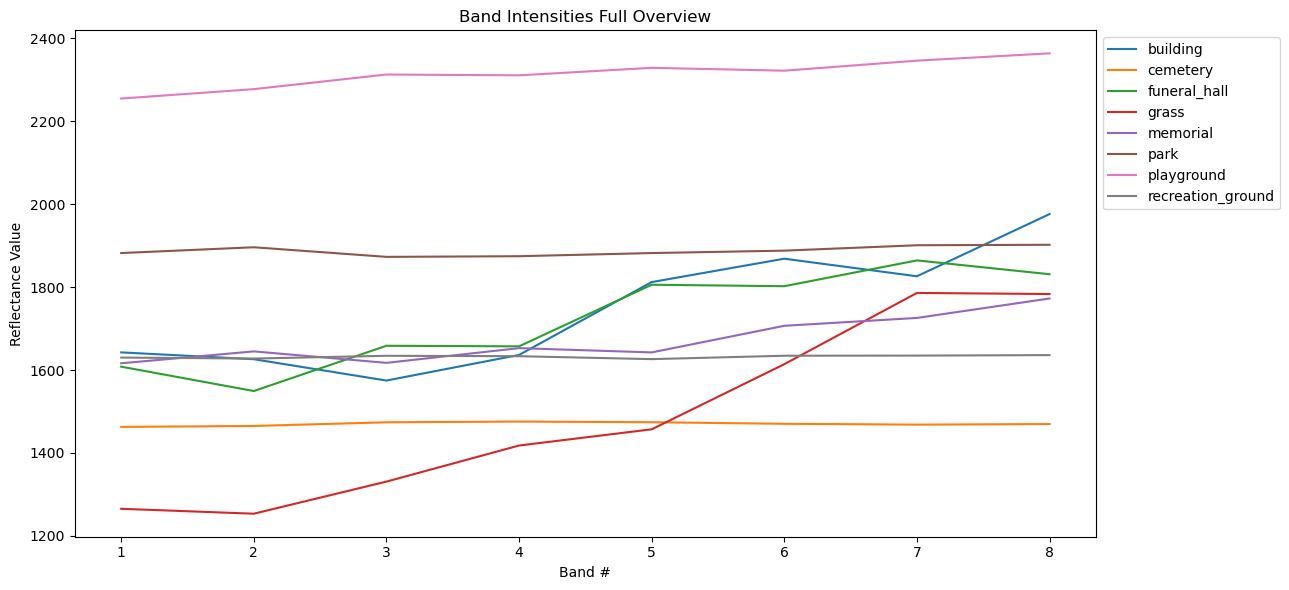

In [175]:
fig, ax = plt.subplots(figsize=[13, 6])

# Numbers 1-8 for bands
band_count = np.arange(1, 9)

# Convert y to numpy array for indexing
y_array = np.array(y)

# Iterate over unique classes
classes = np.unique(y_array)
for class_type in classes:
    # Calculate mean reflectance value for each band for the current class
    band_intensity = np.mean(X[y_array == class_type, :], axis=0)

    # Plot the mean reflectance values on the single plot
    ax.plot(band_count, band_intensity, label=class_type)

# Add axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')

# Add a title
ax.set_title('Band Intensities Full Overview')

# Add legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to accommodate the legend
plt.tight_layout()

# Display the plot
plt.show()

'cemetery'<br>
'funeral_hall'<br>
'grass' <br>
'memorial' <br>
'park' <br>
'playground'<br>
'recreation_ground'

In [176]:
def str_class_to_int(class_array):
    class_array[class_array == 'cemetery'] = 0
    class_array[class_array == 'funeral_hall'] = 1
    class_array[class_array == 'grass'] = 2
    class_array[class_array == 'memorial'] = 3
    class_array[class_array == 'park'] = 4
    class_array[class_array == 'playground'] = 5
    class_array[class_array == 'recreation_ground'] = 6
    class_array[class_array == 'building'] = 7
    return(class_array.astype(int))

## GaussianNB Naive Bayes

In [97]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB()

In [177]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

In [178]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, 400:950, 450:1500]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(8, 550, 1050)
(550, 1050, 8)


In [179]:
class_prediction = gnb.predict(reshaped_img.reshape(-1, 8))

# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

In [180]:
class_prediction = str_class_to_int(class_prediction)

In [181]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (105, 105, 105, 255)),    # cemetery - dark grey
    (1, (230, 230, 250, 255)),    # funeral hall - pale lavender
    (2, (144, 238, 144, 255)),    # grass - light green
    (3, (70, 130, 180, 255)),     # memorial - deep blue
    (4, (60, 179, 113, 255)),     # park - fresh green
    (5, (255, 255, 0, 255)),      # playground - bright yellow
    (6, (255, 165, 0, 255)),      # recreation ground - bright orange
    (7, (255, 0, 0, 255)),        # buildings - red
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

C:\Users\leoni\AppData\Local\Temp\ipykernel_22240\243180734.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


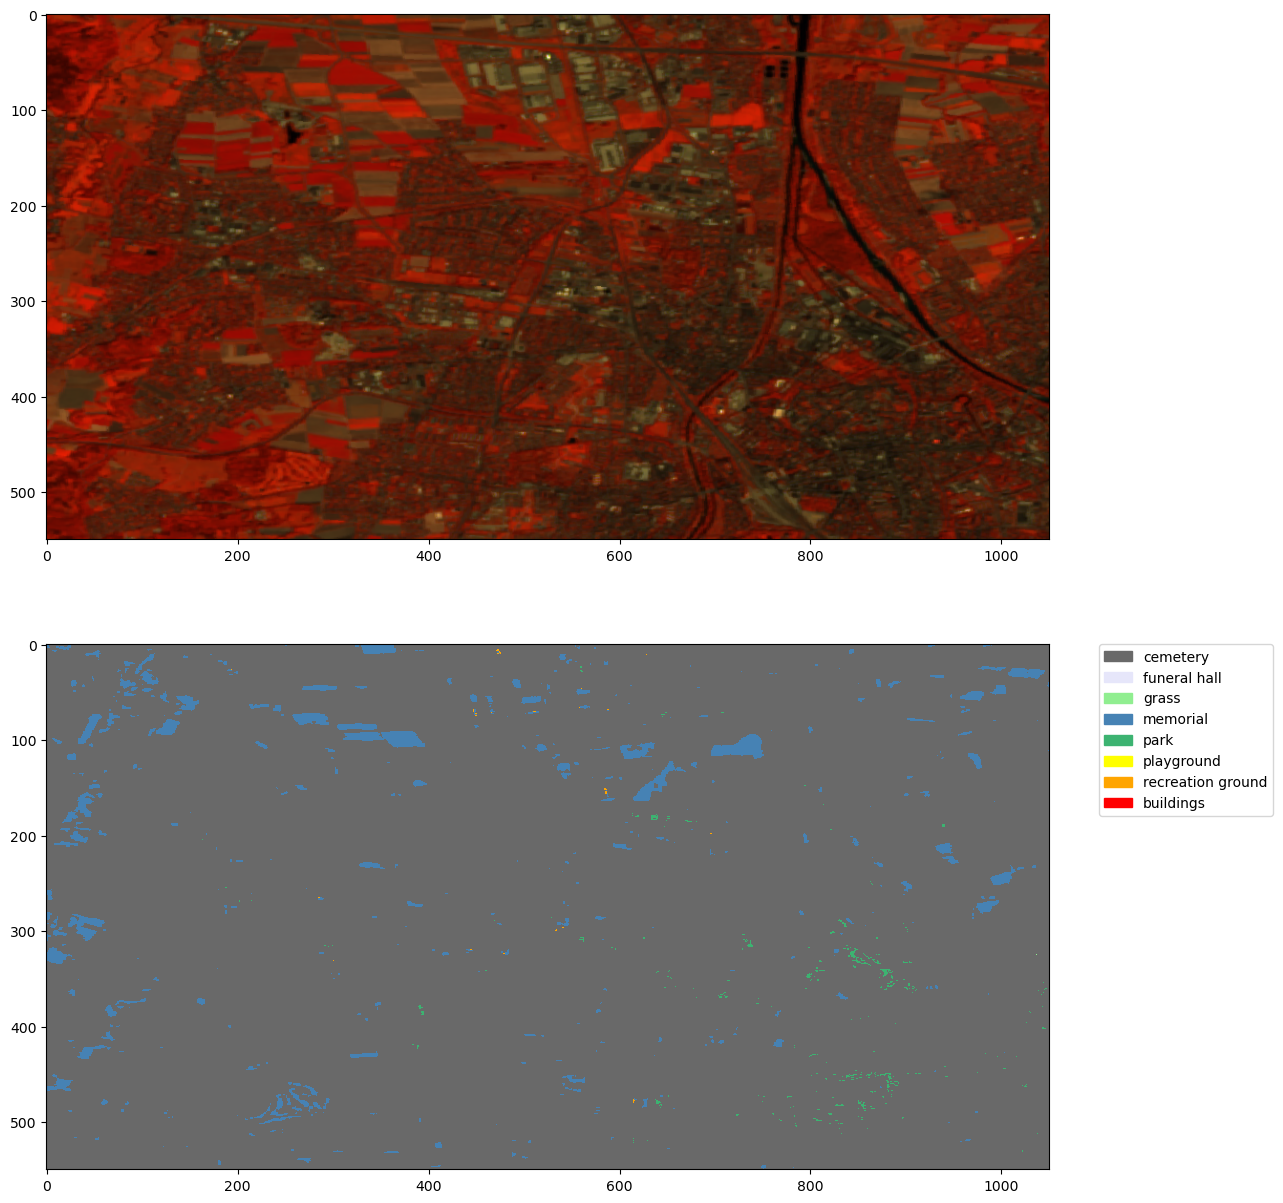

In [182]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Define the class labels and their corresponding colors
class_labels = {
    0: "cemetery",
    1: "funeral hall",
    2: "grass",
    3: "memorial",
    4: "park",
    5: "playground",
    6: "recreation ground",
    7: "buildings"
}

patches = [mpatches.Patch(color=colors[key], label=class_labels[key]) for key in class_labels]

fig, axs = plt.subplots(2,1,figsize=(20,15))

img_stretched = color_stretch(reshaped_img, [7, 3, 2])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')
axs[1].legend(handles=patches, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

fig.show()

In [183]:
with rasterio.open(img_fp) as src:
    green_band = src.read(3)
    red_band = src.read(4)
    nir_band = src.read(8)
    
ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))
ndvi = (nir_band.astype(float) - red_band.astype(float)) / (red_band.astype(float) + nir_band.astype(float))

In [184]:
ndwi = ndwi[150:600, 250:1400]
ndvi = ndvi[150:600, 250:1400]

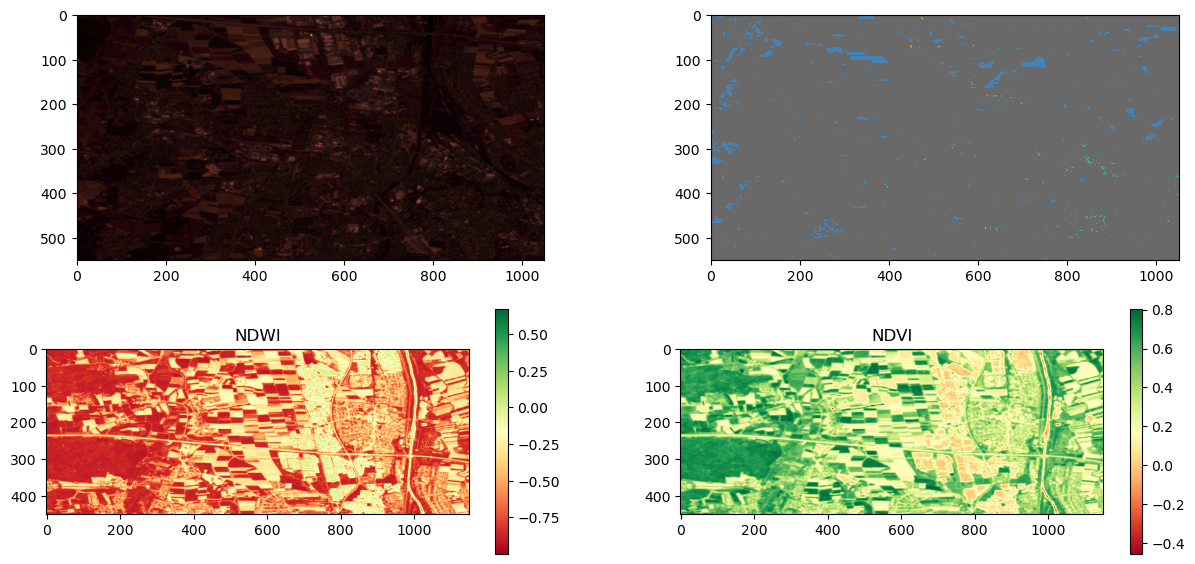

In [185]:
fig, axs = plt.subplots(2,2,figsize=(15,7))

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0,0].imshow(img_stretched)

axs[0,1].imshow(class_prediction, cmap=cmap, interpolation='none')

nwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlGn")
axs[1,0].set_title("NDWI")
fig.colorbar(nwdi_plot, ax=axs[1,0])

ndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")
axs[1,1].set_title("NDVI")
fig.colorbar(ndvi_plot, ax=axs[1,1])

plt.show()

C:\Users\leoni\AppData\Local\Temp\ipykernel_22240\1670099218.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


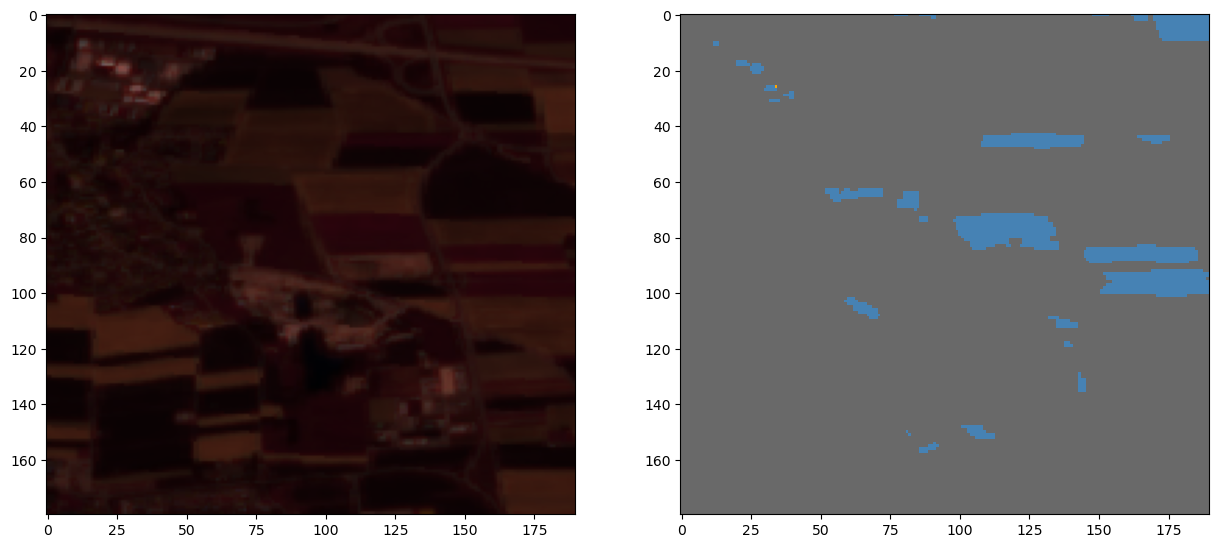

In [186]:
fig, axs = plt.subplots(1,2,figsize=(15,15))

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0].imshow(img_stretched[0:180, 160:350])

axs[1].imshow(class_prediction[0:180, 160:350], cmap=cmap, interpolation='none')

fig.show()

## Random Forest

In [187]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Create the Random Forest model
rf = RandomForestClassifier()

# Train the model
rf.fit(X, y)

RandomForestClassifier()

In [188]:
with rasterio.open(img_fp) as src:
    img = src.read()[:, 400:950, 450:1500]
reshaped_img = reshape_as_image(img)

# Predict the classes using the Random Forest model
class_prediction = rf.predict(reshaped_img.reshape(-1, 8))

# Reshape the classification map for visualization
class_prediction = str_class_to_int(class_prediction) 

In [189]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (105, 105, 105, 255)),    # cemetery - dark grey
    (1, (230, 230, 250, 255)),    # funeral hall - pale lavender
    (2, (144, 238, 144, 255)),    # grass - light green
    (3, (70, 130, 180, 255)),     # memorial - deep blue
    (4, (60, 179, 113, 255)),     # park - fresh green
    (5, (255, 255, 0, 255)),      # playground - bright yellow
    (6, (255, 165, 0, 255)),      # recreation ground - bright orange
    (7, (255, 0, 0, 255)),        # buildings - red
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

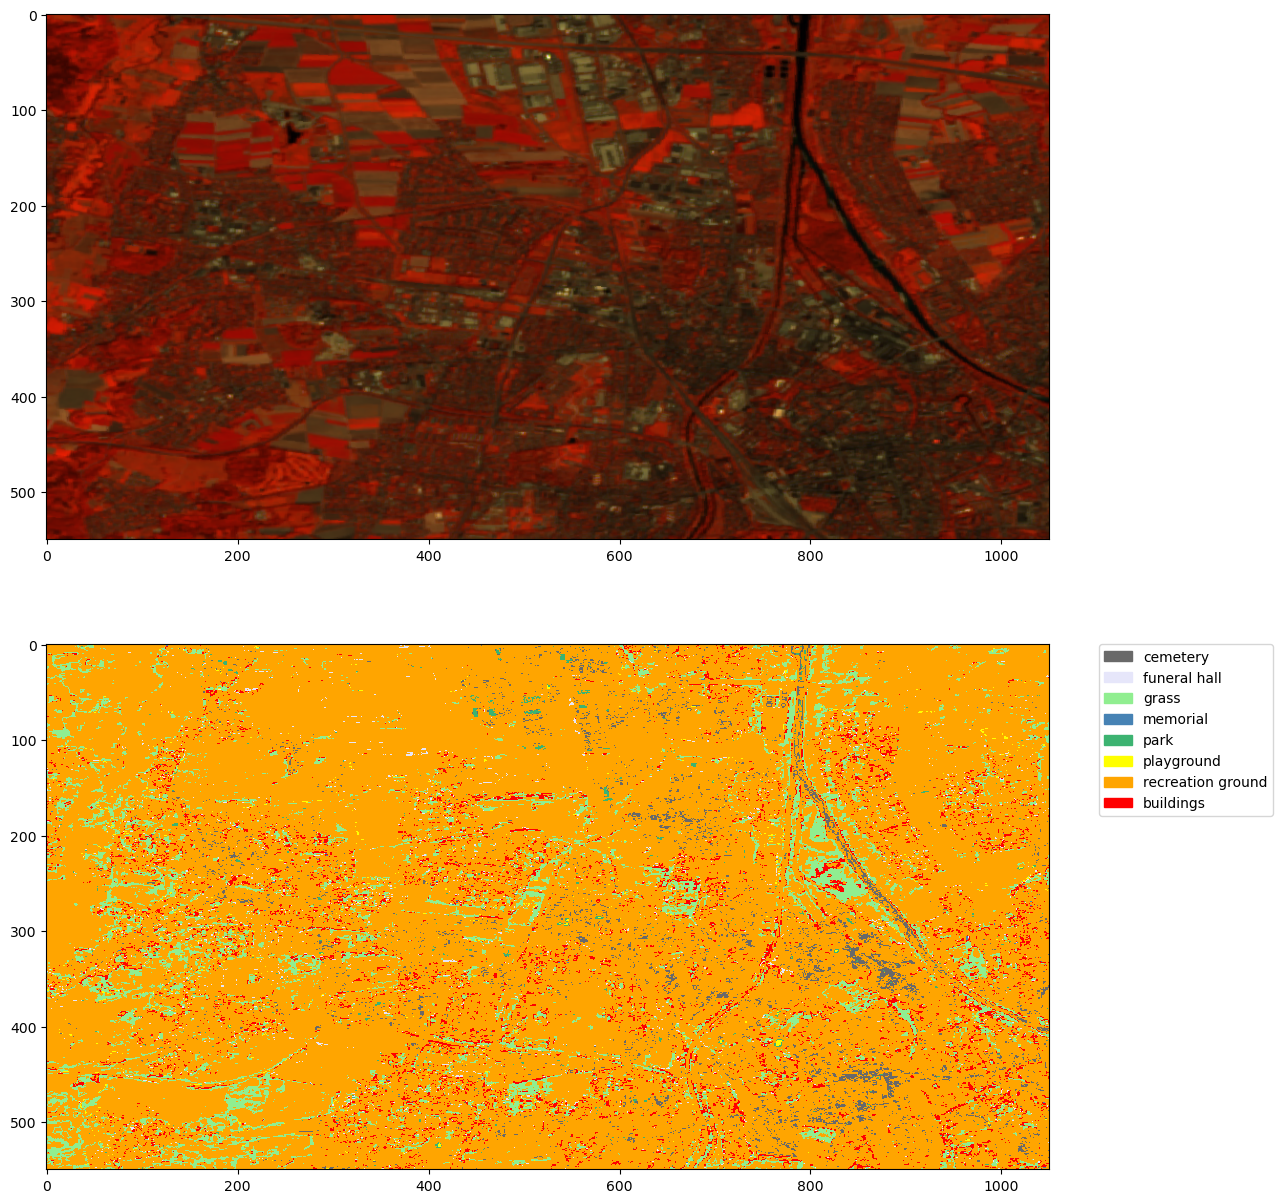

In [190]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Assuming reshaped_img is in the correct format
expected_shape = reshaped_img[:, :, 0].shape
class_prediction_2d = class_prediction.reshape(expected_shape)

fig, axs = plt.subplots(2, 1, figsize=(20, 15))

img_stretched = color_stretch(reshaped_img, [7, 3, 2])
axs[0].imshow(img_stretched)

# Use the reshaped 2D array for visualization
axs[1].imshow(class_prediction_2d, cmap=cmap, interpolation='none')
axs[1].legend(handles=patches, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()

## KMeans

c:\Users\leoni\Programme\Miniconda\envs\geo\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


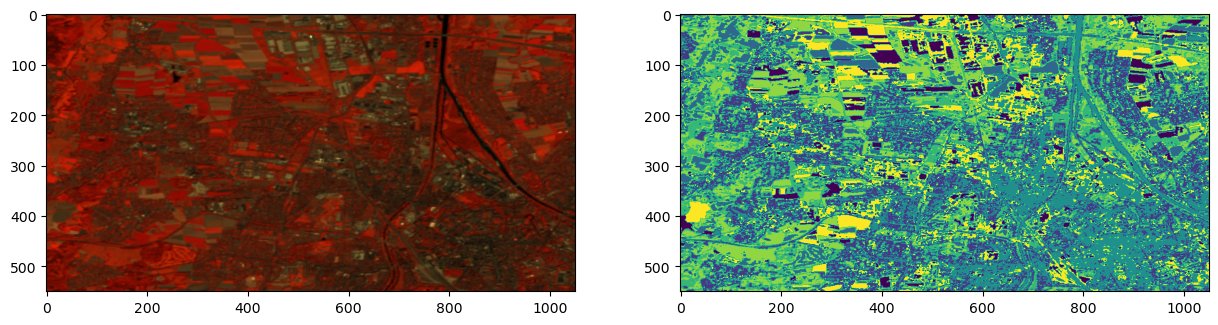

In [192]:
from sklearn.cluster import KMeans

bands, rows, cols = img.shape

k = 7 # num of clusters

kmeans_predictions = KMeans(n_clusters=k, random_state=0).fit(reshaped_img.reshape(-1, 8))

kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

# Now show the classmap next to the image
fig, axs = plt.subplots(1,2,figsize=(15,8))

img_stretched = color_stretch(reshaped_img, [7, 3, 2]) #try different band combinations
axs[0].imshow(img_stretched)

axs[1].imshow(kmeans_predictions_2d)

## KNeighbours

In [193]:
from sklearn.neighbors import KNeighborsClassifier

# Create the KNN model
knn = KNeighborsClassifier()

# Train the model
knn.fit(X, y)

KNeighborsClassifier()

In [194]:
with rasterio.open(img_fp) as src:
    img = src.read()[:, 400:950, 450:1500]
reshaped_img = reshape_as_image(img)

# Predict the classes using the KNN model
class_prediction = knn.predict(reshaped_img.reshape(-1, 8))

# Reshape the classification map for visualization
class_prediction = str_class_to_int(class_prediction)

In [195]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (105, 105, 105, 255)),    # cemetery - dark grey
    (1, (230, 230, 250, 255)),    # funeral hall - pale lavender
    (2, (144, 238, 144, 255)),    # grass - light green
    (3, (70, 130, 180, 255)),     # memorial - deep blue
    (4, (60, 179, 113, 255)),     # park - fresh green
    (5, (255, 255, 0, 255)),      # playground - bright yellow
    (6, (255, 165, 0, 255)),      # recreation ground - bright orange
    (7, (255, 0, 0, 255)),        # buildings - red
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

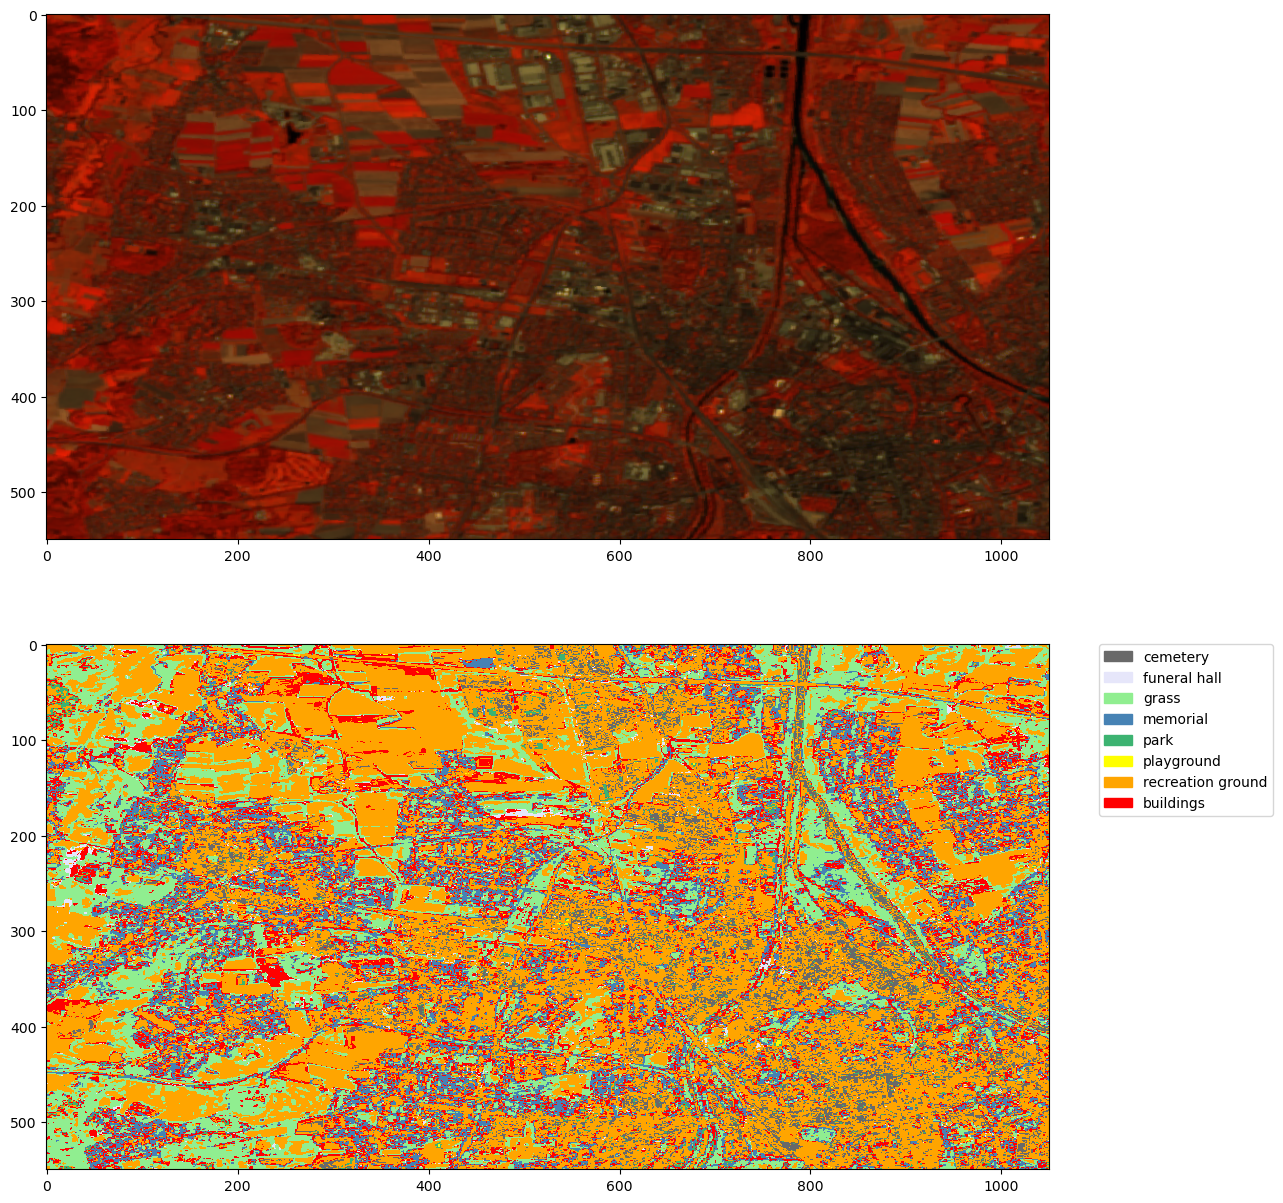

In [196]:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))

img_stretched = color_stretch(reshaped_img, [7, 3, 2])
axs[0].imshow(img_stretched)

class_prediction_2d = class_prediction.reshape(reshaped_img[:, :, 0].shape)
axs[1].imshow(class_prediction_2d, cmap=cmap, interpolation='none')
axs[1].legend(handles=patches, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()

## Decision Tree

In [197]:
from sklearn.tree import DecisionTreeClassifier

# Create the Decision Tree model
dt = DecisionTreeClassifier()

# Train the model
dt.fit(X, y)

DecisionTreeClassifier()

In [198]:
# Read and reshape the image
with rasterio.open(img_fp) as src:
    img = src.read()[:, 400:950, 450:1500]
reshaped_img = reshape_as_image(img)

# Predict the classes using the Decision Tree model
class_prediction = dt.predict(reshaped_img.reshape(-1, 8))

# Reshape the classification map for visualization
class_prediction = str_class_to_int(class_prediction)

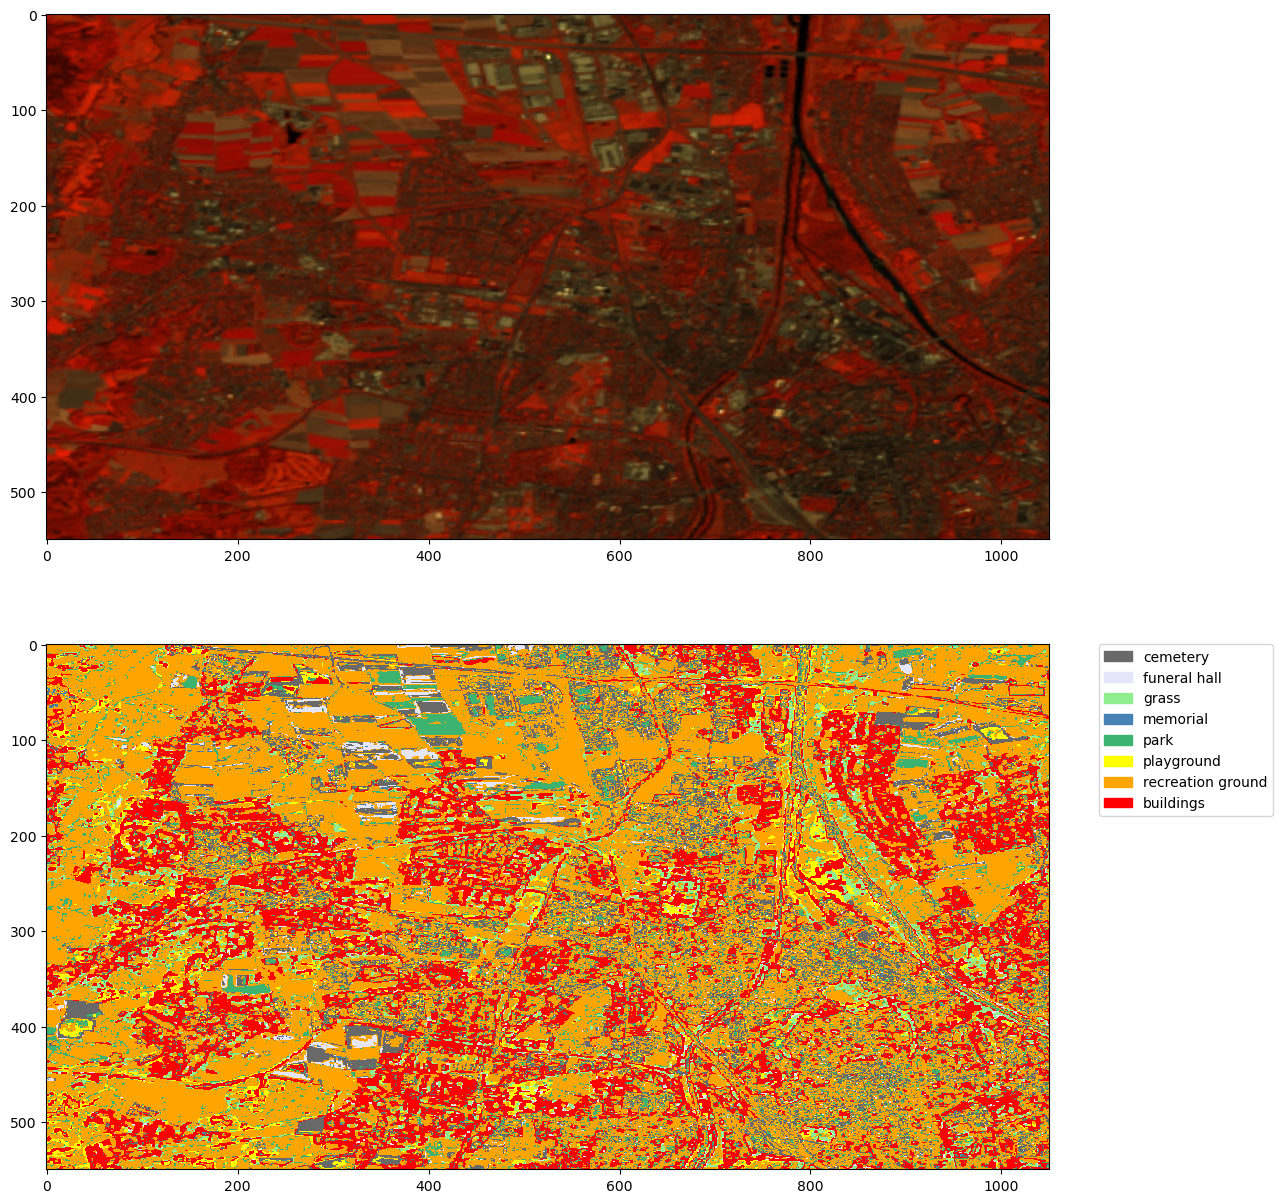

In [199]:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))

img_stretched = color_stretch(reshaped_img, [7, 3, 2])
axs[0].imshow(img_stretched)

class_prediction_2d = class_prediction.reshape(reshaped_img[:, :, 0].shape)
axs[1].imshow(class_prediction_2d, cmap=cmap, interpolation='none')
axs[1].legend(handles=patches, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.show()